# Network Analysis of ERP Components

Analyze the network of ERP papers - based on connections of papers that discuss multiple ERPs.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import networkx as nx

from lisc.utils import SCDB, load_object

## Helper Functions

The following functions are for scaling data, to be used to scale the weight edges. 

In [2]:
# Functions to rescale edge weight to a new range for plotting
# From here: http://stackoverflow.com/questions/929103/convert-a-number-range-to-another-range-maintaining-ratio
def scale_number(unscaled, to_min, to_max, from_min, from_max):
    """Scale a number to be within a given range."""
    return (to_max-to_min)*(unscaled-from_min)/(from_max-from_min)+to_min

def scale_list(lst, to_min, to_max):
    """Scale a list of number to a given range."""
    return [scale_number(ind, to_min, to_max, min(lst), max(lst)) for ind in lst]

## Setup

In [3]:
# Settings
SAVE_FIG = False
SAVE_EXT = '.svg'

In [4]:
# Set the name of the file to load
name = 'erps' # 'erps', 'test'

# Set the minimum number of papers for including a component
n_min = 150

In [5]:
# Set the file locations
db = SCDB('../data/')
figs_dir = '../data/figures/network/'

In [6]:
# Load data
words = load_object('words_' + name, directory=db, reload_results=True)

In [7]:
# Drop components without enough articles
words.drop_data(n_min)

## Set up Network

In [8]:
# Calculate the connections between components, based on overlapping articles
overlaps = np.zeros(shape=(words.n_terms, words.n_terms))
for ii, ei in enumerate(words.labels):
    for jj, ej in enumerate(words.labels):
        overlaps[ii, jj] = len(set(words[ei].ids) & set(words[ej].ids))

In [9]:
# Initialize network graph, and add the nodes
network = nx.Graph()
for ind, erp in enumerate(words.labels):
    network.add_node(ind)

In [10]:
# Add weighted edges between nodes
for ii in range(words.n_terms):
    for jj in range(words.n_terms):
        if overlaps[ii, jj] > 0:
            network.add_edge(ii, jj, weight=overlaps[ii, jj])

In [11]:
# Collect the labels for each node
labels = {ind : label for ind, label in enumerate(words.labels)}

In [12]:
# Drop any listed ERPs from the network
#   Components without connections to the network are dropped
drop_erps = ['VsEP']
drop_inds = [words.get_index(erp) for erp in drop_erps]
for ind in drop_inds:
    network.remove_node(ind)
    labels.pop(ind)

### Plot the ERP network

In [13]:
# Settings for the network plot
f_size = (12, 8)
alpha = 0.9
node_size = 80

In [14]:
# Get the location information for plotting the graph
pos = nx.spring_layout(network)

In [15]:
# Compute the edges weights to visualize in the plot
weights = [network[ii][jj]['weight'] for ii, jj in network.edges()]
widths = scale_list(weights, 0.1, 10)

# Update the label positions to offset them from on top of nodes
label_pos = {ind : array + [0, 0.05] for ind, array in pos.items()}

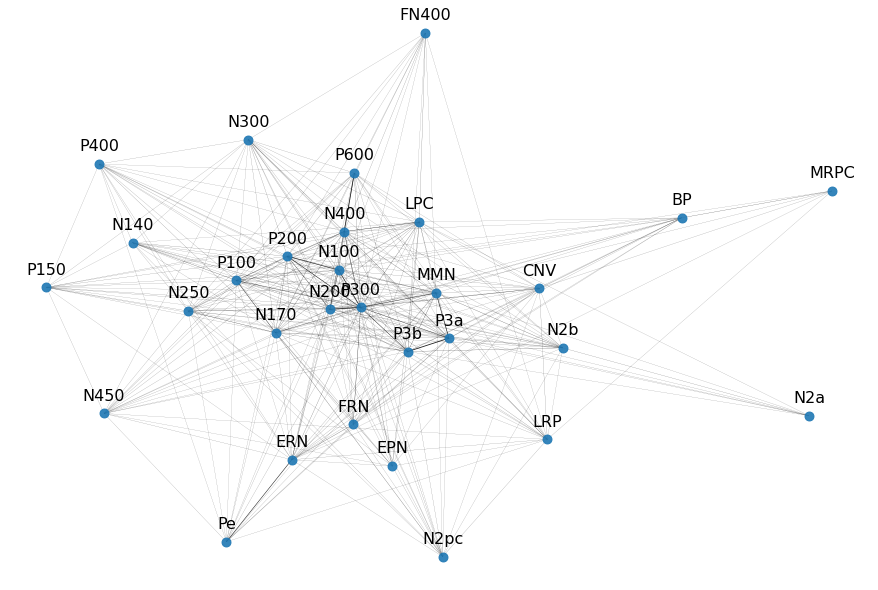

In [16]:
# Create the network plot
plt.figure(figsize=f_size)
nx.draw(network, pos=pos, node_size=node_size, alpha=alpha, width=widths)
nx.draw_networkx_labels(network, label_pos, labels=labels, font_size=16);
if SAVE_FIG:
    file_name = 'erp_network'
    file_path = figs_dir + file_name + SAVE_EXT
    plt.savefig(file_path, transparent=True)

## Measures

Evaluate some descriptive measures of the ERP network.

In [17]:
# Check centers
centers = nx.center(network)
erp_centers = [labels[ii] for ii in centers]
print(erp_centers)

['P300']


In [18]:
# Check some descriptive statistics of the network
print('Average clustering: \t\t{:1.2f}'.format(nx.average_clustering(network)))
print('Average node connectivity: \t{:1.2f}'.format(nx.average_node_connectivity(network)))
print('Average shortest path length: \t{:1.2f}'.format(nx.average_shortest_path_length(network)))

Average clustering: 		0.84
Average node connectivity: 	17.00
Average shortest path length: 	1.29


In [19]:
# Check average degree
degs = [val for key, val in network.degree]
print('Average degree: \t\t{:1.2f}'.format(np.mean(degs)))

Average degree: 		22.60
